# 실습 [18-1]<br>
**실습명: CNN을 이용한 문장 분류 모델에 GloVe 벡터 적용**<br>
: CNN을 이용해서 문장을 여러 카테고리 중 하나로 분류하는 모델 생성, 미리 학습된 단어 벡터를 모델에 적용
- GloVe : 단어 단위 임베딩 방법으로, 단어벡터공간 상에서 연산을 통한 의미 표현을 주요 목표로 갖고 있음 (단어간 동시 발생 비율을 벡터 공간 상 표시)


In [ ]:
#관련 라이브러리 불러오기
import os
import pandas as pd
import numpy as np
from collections import Counter
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#Stanford 대학에서 구성한 공손함 데이터
if not os.path.exists("Stanford_politeness_corpus.zip"):
  !wget http://www.cs.cornell.edu/~cristian/Politeness_files/Stanford_politeness_corpus.zip

if not os.path.exists("Stanford_politeness_corpus/wikipedia.annotated.csv"):
  !unzip Stanford_politeness_corpus.zip

--2021-06-21 06:37:06--  http://www.cs.cornell.edu/~cristian/Politeness_files/Stanford_politeness_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34676352 (33M) [application/zip]
Saving to: ‘Stanford_politeness_corpus.zip’

Stanford_politeness 100%[===================>]  33.07M  84.4MB/s    in 0.4s    

2021-06-21 06:37:06 (84.4 MB/s) - ‘Stanford_politeness_corpus.zip’ saved [34676352/34676352]

Archive:  Stanford_politeness_corpus.zip
   creating: Stanford_politeness_corpus/
  inflating: Stanford_politeness_corpus/Readme.txt  
  inflating: Stanford_politeness_corpus/stack-exchange.annotated.csv  
  inflating: Stanford_politeness_corpus/stack-exchange.requests.csv  
  inflating: Stanford_politeness_corpus/stack-exchange.roles.csv  
  inflating: Stanford_politeness_corpus/wikipedia.admins.csv  
  inflating: Stanford_



```load_data(data_file):``` 함수로 데이터 불러오기
- bottom quartile (공손하지 않음): 하위 25% (0으로 마킹)
- top quartile (공손함): 상위 25% (1로 마킹)
- neutral (중립적): (2로 마킹)

In [ ]:
def load_data(data_file):
  data = pd.read_csv(data_file)

  # Only use the top quartile as polite, and bottom quartile as impolite. Discard the rest.
  quantiles = data["Normalized Score"].quantile([0.25, 0.5, 0.75])
  print(quantiles)

  for i in range(len(data)):
    score = data.loc[i, "Normalized Score"]
    if score <= quantiles[0.25]:
      # Bottom quartile (impolite).
      data.loc[i, "Normalized Score"] = 0
    elif score >= quantiles[0.75]:
      # Top quartile (polite).
      data.loc[i, "Normalized Score"] = 1
    else:
      # Neutral.
      data.loc[i, "Normalized Score"] = 2

  data["Normalized Score"] = data["Normalized Score"].astype(int)

  # Discard neutral examples.
  data = data[data["Normalized Score"] < 2] #0(impolite)과 1(polite)만 가져감
  data = data.sample(frac=1).reset_index(drop=True)

  return data

In [ ]:
data = load_data("Stanford_politeness_corpus/wikipedia.annotated.csv")
pd.set_option('display.max_columns', None)

print(data.head())

0.25   -0.442633
0.50    0.052339
0.75    0.514399
Name: Normalized Score, dtype: float64
   Community      Id                                            Request  \
0  Wikipedia  627958                                                ???   
1  Wikipedia  458817    Don't worry I understand. Using igloo I assume?   
2  Wikipedia  622914  That's the British English spelling. American ...   
3  Wikipedia  124118  I didn't have those in <person> because they w...   
4  Wikipedia  411440  Thanks, but I've already read those essays.  D...   

   Score1  Score2  Score3  Score4  Score5         TurkId1         TurkId2  \
0      11      10       1      13      13   AW6UIL04MLQ9N  A21FGAQF6DQ9D9   
1      25      17      18      18      17   ANMGOZ451W9ZN   AW6UIL04MLQ9N   
2       9      12       5       8      11  A233ONYNWKDIYF  A1JMINVUZ2AOZR   
3      13       5      13      17       7  A2UFD1I8ZO1V4G  A26YKYQIA3GX8B   
4      11      11      15       7       3   AYG3MF094634L  A3LXBP8T6JMY9B 

다음으로 할 일은 사전을 구성하는 것입니다.

신경망의 입력으로 사용하기 위해서는 문장을 숫자로 바꿔야 하는데, 사전의 역할은 단어를 숫자로, 숫자를 단어로 바꿔주는 것입니다. (단어 임베딩의 역할)
- 빠른 계산을 위해 dictionary 자료구조 사용

1. 문장들을 소문자로 바꾸고, tokenization (nltk.tokenize 패키지의 word_tokenize 함수 활용)
2. 전체 데이터에서 각 토큰들의 등장 빈도 확인 (collections 패키지의 Counter 클래스 활용)
3. 가장 등장 빈도가 높은 단어를 vocab_size 만큼 선택 (Counter의 most_common 함수 활용)
4. 각각의 단어에 고유한 숫자 부여. 이때, 0번째 토큰은 "
5. 토큰 -> 숫자 변환을 위한 dictionary (word_index 변수에 할당)
<br>숫자 -> 토큰 변환을 위한 dictionary (word_inverted_index 변수에 할당) 생성

In [ ]:
vocab_size = 5000
# we assign the first indices in the vocabulary to special tokens that we use
# for padding, and for indicating unknown words
pad_id = 0
oov_id = 1
index_offset = 1

#사전 구성(단어집)
def make_vocab(sentences):
  word_counter = Counter()

  for sent in sentences:
    tokens = word_tokenize(sent.lower()) #소문자로 바꿔주기
    word_counter.update(tokens) #tokenization
  
  most_common = word_counter.most_common() #등장빈도 확인 후 가장 고빈도의 단어 선택
  print("고빈도 단어:")
  for k, v in most_common[:10]:
    print(k, ": ", v)
  
  vocab = { #각 단어에 고유한 숫자 번호 부여(pad_id, oov_id)
      '<PAD>': pad_id,
      '<OOV>': oov_id
  }
  for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
    vocab[word] = i
    if len(vocab) >= vocab_size:
      break
  
  return vocab
  
sentences = data["Request"].tolist()
word_index = make_vocab(sentences)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
  print(i, word_inverted_index[i])
  
print("\n단어 사전 크기: ", len(word_index))

고빈도 단어:
? :  2714
the :  2499
you :  2235
, :  2204
to :  1695
i :  1679
. :  1642
a :  1125
it :  963
that :  936

단어 사전:
0 <PAD>
1 <OOV>
2 ?
3 the
4 you
5 ,
6 to
7 i
8 .
9 a

단어 사전 크기:  5000


In [ ]:
def index_to_text(indexes): #숫자 -> 토큰
  return ' '.join([word_inverted_index[i] for i in indexes])
  
def text_to_index(text): #토큰 -> 숫자
  tokens = tokens = word_tokenize(text.lower())
  indexes = []
  for tok in tokens:
    if tok in word_index:
      indexes.append(word_index[tok])
    else:
      indexes.append(oov_id)
      
  return indexes

print("원본: ", sentences[0])
ids = text_to_index(sentences[0])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  ???
문자 -> 숫자:  [2, 2, 2]
숫자 -> 문자:  ? ? ?


숫자로 바뀐 문장들을 학습 데이터로 사용할 수 있도록 변형하겠습니다.

1. 모든 문장들을 동일한 길이가 되도록 padding 처리하거나 자름 (tensorflow.python.keras.preprocessing.sequence 패키지의 pad_sequence 함수 활용)
2. 데이터의 일부(10%)를 테스트 데이터로 분리

In [ ]:
x_variable = [text_to_index(sent) for sent in sentences]

#모든 문장 동일한 길이 -> padding 처리
sentence_size = 200
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

#data셋 중에서 10%만 테스트 데이터로 분리
n_test = len(data) // 10
test_inputs = x_padded[:n_test]
train_inputs = x_padded[n_test:]

ys = np.array(data["Normalized Score"].tolist())
test_labels = ys[:n_test]
train_labels = ys[n_test:]

print("test_inputs shape: ", test_inputs.shape)
print("train_inputs shape: ", train_inputs.shape)
print("test_labels shape: ", test_labels.shape)
print("train_labels shape: ", train_labels.shape)

test_inputs shape:  (217, 200)
train_inputs shape:  (1961, 200)
test_labels shape:  (217,)
train_labels shape:  (1961,)


keras.Sequential을 이용하여 CNN 모델을 구성해봅시다. Sequential 모델을 사용하려면 동일한 크기의 필터만 사용할 수 있습니다.

참고 함수:
- keras.layers.Embedding
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding (단어 임베딩 계층)

- keras.layers.Conv1D
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D (Convolutional 계층)

- keras.layers.GlobalMaxPool1D
https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D (Pooling 계층)

- keras.layers.Dense
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense <br>
(Dense 계층, input/output shape를 특정짓는 계층)

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 50),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [ ]:
#학습 결과 시각화
def plot_loss(history):
  plt.figure(figsize=(6,5))
  val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
  plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.legend()

  plt.xlim([0,max(history.epoch)])

#성능 측정
def eval_model(model):
  test_loss, test_acc = model.evaluate(test_inputs, test_labels)
  print('Test accuracy:', test_acc)

Epoch 1/10
62/62 [==============================] - 2s 18ms/step - loss: 0.6787 - accuracy: 0.5910 - val_loss: 0.6386 - val_accuracy: 0.7143
Epoch 2/10
62/62 [==============================] - 1s 15ms/step - loss: 0.5643 - accuracy: 0.8241 - val_loss: 0.4981 - val_accuracy: 0.8111
Epoch 3/10
62/62 [==============================] - 1s 16ms/step - loss: 0.4086 - accuracy: 0.8878 - val_loss: 0.4146 - val_accuracy: 0.8387
Epoch 4/10
62/62 [==============================] - 1s 16ms/step - loss: 0.2899 - accuracy: 0.9199 - val_loss: 0.3843 - val_accuracy: 0.8341
Epoch 5/10
62/62 [==============================] - 1s 16ms/step - loss: 0.1942 - accuracy: 0.9582 - val_loss: 0.3785 - val_accuracy: 0.8295
Epoch 6/10
62/62 [==============================] - 1s 15ms/step - loss: 0.1244 - accuracy: 0.9786 - val_loss: 0.3800 - val_accuracy: 0.8249
Epoch 7/10
62/62 [==============================] - 1s 16ms/step - loss: 0.0769 - accuracy: 0.9913 - val_loss: 0.3911 - val_accuracy: 0.8341
Epoch 8/10
62

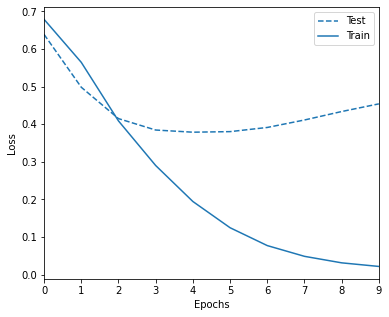

In [ ]:
#모델 학습
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_inputs,
          train_labels,
          epochs=10,
          validation_data=(test_inputs, test_labels)
         )

plot_loss(history)
eval_model(model)

**사전 학습된 단어 임베딩 모델 (GloVe) 사용**

In [ ]:
if not os.path.exists('glove.6B.zip'):
    ! wget http://nlp.stanford.edu/data/glove.6B.zip
if not os.path.exists('glove.6B.50d.txt'):
    ! unzip glove.6B.zip
    
! head glove.6B.50d.txt

--2021-06-21 06:59:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-21 06:59:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-21 06:59:25--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

GloVe 벡터를 불러와서 임베딩 행렬을 초기화해보겠습니다.

1. GloVe 파일을 읽고, 각 줄에서 단어(1번째 토큰)와 벡터를 이루는 숫자들(2번째 이후 토큰들)을 분리
2. 벡터를 이루는 숫자들을 numpy 행렬로 변환 (numpy의 asarray 함수 활용)
3. 단어와 벡터를 연결하는 dictionary 자료구조 구성 (단어 -> 벡터)
4. 모든 단어들에 대한 임베딩 행렬을 무작위로 생성 (vocab_size X 50 크기의 numpy 행렬)
5. 임베딩 행렬에서, GloVe 벡터가 존재하는 단어들만 해당 GloVe 벡터로 대체

In [ ]:
def load_glove_embeddings(path):
    embeddings = {} #dictionary 구조
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0] #단어
            vectors = np.asarray(values[1:], dtype='float32') #숫자들 numpy 행렬로 변환
            embeddings[w] = vectors #단어와 숫자 연결

    embedding_matrix = np.random.uniform(-1, 1, size=(vocab_size, 50)) #임베딩 행렬 생성
    num_loaded = 0
    for w, i in word_index.items(): #GloVe 벡터가 존재하는 단어 -> GloVe 벡터로 대체
        v = embeddings.get(w)
        if v is not None and i < vocab_size:
            embedding_matrix[i] = v
            num_loaded += 1
    print('Successfully loaded pretrained embeddings for '
          f'{num_loaded}/{vocab_size} words.')
    embedding_matrix = embedding_matrix.astype(np.float32)
    return embedding_matrix

embedding_matrix = load_glove_embeddings('glove.6B.50d.txt')

Successfully loaded pretrained embeddings for 4380/5000 words.


앞서 사용된 모델에서, Embedding layer의 값을 위에서 생성한 임베딩 행렬로 초기화해봅시다. (`keras.initializers.Constant` 클래스 활용)

In [ ]:
glove_init = keras.initializers.Constant(embedding_matrix)

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 50, embeddings_initializer=glove_init),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

Epoch 1/10
62/62 [==============================] - 2s 19ms/step - loss: 0.7342 - accuracy: 0.5380 - val_loss: 0.6601 - val_accuracy: 0.6037
Epoch 2/10
62/62 [==============================] - 1s 17ms/step - loss: 0.6026 - accuracy: 0.6757 - val_loss: 0.5970 - val_accuracy: 0.6820
Epoch 3/10
62/62 [==============================] - 1s 18ms/step - loss: 0.5190 - accuracy: 0.7853 - val_loss: 0.5501 - val_accuracy: 0.7235
Epoch 4/10
62/62 [==============================] - 1s 17ms/step - loss: 0.4400 - accuracy: 0.8628 - val_loss: 0.5027 - val_accuracy: 0.7926
Epoch 5/10
62/62 [==============================] - 1s 17ms/step - loss: 0.3609 - accuracy: 0.9006 - val_loss: 0.4606 - val_accuracy: 0.7834
Epoch 6/10
62/62 [==============================] - 1s 17ms/step - loss: 0.2921 - accuracy: 0.9301 - val_loss: 0.4365 - val_accuracy: 0.8018
Epoch 7/10
62/62 [==============================] - 1s 17ms/step - loss: 0.2365 - accuracy: 0.9465 - val_loss: 0.4235 - val_accuracy: 0.7926
Epoch 8/10
62

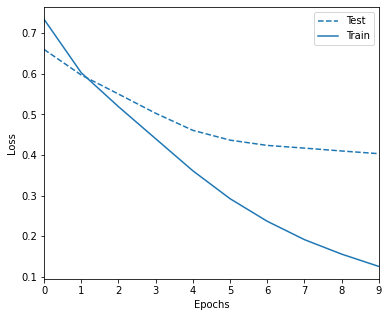

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_inputs,
          train_labels,
          epochs=10,
          validation_data=(test_inputs, test_labels)
         )

plot_loss(history)
eval_model(model)

# 실습 [18-2]<br>
**실습명: BERT을 이용한 문장 분류**<br>

In [ ]:
#데이터 다운로드
import os

if not os.path.exists("Stanford_politeness_corpus.zip"):
  !wget http://www.cs.cornell.edu/~cristian/Politeness_files/Stanford_politeness_corpus.zip

if not os.path.exists("Stanford_politeness_corpus/wikipedia.annotated.csv"):
  !unzip Stanford_politeness_corpus.zip

In [ ]:
!head Stanford_politeness_corpus/wikipedia.annotated.csv

Community,Id,Request,Score1,Score2,Score3,Score4,Score5,TurkId1,TurkId2,TurkId3,TurkId4,TurkId5,Normalized Score
Wikipedia,629705,Where did you learn English? How come you're taking on a third language?,13,9,11,11,5,A2UFD1I8ZO1V4G,A2YFPO0N4GIS25,AYG3MF094634L,A38WUWONC7EXTO,A15DM9BMKZZJQ6,-1.1200492637766977
Wikipedia,244336,Thanks very much for your edit to the <url> article. Would you be interested in tackling the <url> of <url>?,23,16,24,21,25,A2QN0EGBRGJU1M,A2GSW5RBAT5LQ5,AO5E3LWBYM72K,A2ULMYRKQMNNFG,A3TFQK7QK8X6LM,1.3139550758835656
Wikipedia,627353,Sir i think u hav many friends on wiki who can review articles well. can u pls consult any of them?,17,17,11,10,9,A233ONYNWKDIYF,A2UFD1I8ZO1V4G,A2MWGIVIKOXWYM,A1F4D2PZ7NNWTL,A1RT9SQ9D9DLOV,-0.24794144023792447
Wikipedia,448565,I can't find it.  Maybe I didn't manage to guess the right name; can you find it in your contribs?,17,9,16,16,9,A233ONYNWKDIYF,A1TLLJDX8H4JP1,AC25X12LNYY6Y,A1F4D2PZ7NNWTL,AEYHIQUDWJ3KV,0.058298305157442387
Wikipe

한 줄이 하나의 데이터를 나타내고, 각 데이터 값들은 쉼표로 구분되어 있는 것을 볼 수 있습니다.

또한, 첫 줄은 각 데이터 값들이 어떤 항목을 나타내는지 알려주는 헤더입니다.

이런 형식의 데이터 파일은 pandas의 read_csv 함수를 이용하여 쉽게 불러올 수 있습니다.

In [ ]:
import urllib
import pandas as pd

data = pd.read_csv("Stanford_politeness_corpus/wikipedia.annotated.csv")
pd.set_option('display.max_columns', None)

print(data.head())

   Community      Id                                            Request  \
0  Wikipedia  629705  Where did you learn English? How come you're t...   
1  Wikipedia  244336  Thanks very much for your edit to the <url> ar...   
2  Wikipedia  627353  Sir i think u hav many friends on wiki who can...   
3  Wikipedia  448565  I can't find it.  Maybe I didn't manage to gue...   
4  Wikipedia  625810  I can't spend too much time, and I'm no specia...   

   Score1  Score2  Score3  Score4  Score5         TurkId1         TurkId2  \
0      13       9      11      11       5  A2UFD1I8ZO1V4G  A2YFPO0N4GIS25   
1      23      16      24      21      25  A2QN0EGBRGJU1M  A2GSW5RBAT5LQ5   
2      17      17      11      10       9  A233ONYNWKDIYF  A2UFD1I8ZO1V4G   
3      17       9      16      16       9  A233ONYNWKDIYF  A1TLLJDX8H4JP1   
4      17      14      17      11      17  A21753FQKCM5DQ   AYG3MF094634L   

          TurkId3         TurkId4         TurkId5  Normalized Score  
0   AYG3MF094634

In [ ]:
#bert-tensorflow 패키지는 구글에서 공개한 BERT의 코드로부터 BERT 사용에 필요한 함수들을 활용할 수 있게 해줍니다.
! pip install bert-tensorflow

     |████████████████████████████████| 71kB 8.5MB/s 


In [ ]:
import math
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import pickle
import bert
import os
from bert import run_classifier #tensorflow.contrib는 ver2.0.0 이하에서만 지원됨
from bert import optimization
from bert import tokenization

tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
def create_tokenizer_from_hub_module(bert_model_hub):
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(bert_model_hub)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                                  tokenization_info["do_lower_case"]])

        print("Using BERT from %s" %bert_model_hub)
        print("with vocab size=%d and do_lower_case=%s." %(len(vocab_file), str(do_lower_case)))

    return bert.tokenization.FullTokenizer(
        vocab_file=vocab_file, do_lower_case=do_lower_case)


def make_features(dataset, label_list, MAX_SEQ_LENGTH, tokenizer, DATA_COLUMN, LABEL_COLUMN):
    input_example = dataset.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                             text_a=x[DATA_COLUMN],
                                                                             text_b=None,
                                                                             label=x[LABEL_COLUMN]), axis=1)
    features = bert.run_classifier.convert_examples_to_features(input_example, label_list, MAX_SEQ_LENGTH, tokenizer)
    return features


def create_model(bert_model_hub, is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
    """Creates a classification model."""

    bert_module = hub.Module(
        bert_model_hub,
        trainable=True)
    bert_inputs = dict(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids)
    bert_outputs = bert_module(
        inputs=bert_inputs,
        signature="tokens",
        as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    with tf.variable_scope("output_layer"):
        layer_out = tf.layers.dense(
            inputs=output_layer,
            units=num_labels,
            use_bias=False,
            kernel_initializer=tf.initializers.variance_scaling()
        )
        predicted_labels = tf.squeeze(tf.argmax(layer_out, axis=-1, output_type=tf.int32))

        if is_predicting:
            return predicted_labels, layer_out
        else:
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=labels,
                logits=layer_out
            )
            loss = tf.reduce_mean(loss)

            return loss, predicted_labels, layer_out

In [ ]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(bert_model_hub, num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

        # TRAIN and EVAL
        if not is_predicting:

            (loss, predicted_labels, log_probs) = create_model(
                bert_model_hub, is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            train_op = bert.optimization.create_optimizer(
                loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

            # Calculate evaluation metrics.
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                f1_score = tf.contrib.metrics.f1_score(
                    label_ids,
                    predicted_labels)
                auc = tf.metrics.auc(
                    label_ids,
                    predicted_labels)
                recall = tf.metrics.recall(
                    label_ids,
                    predicted_labels)
                precision = tf.metrics.precision(
                    label_ids,
                    predicted_labels)
                true_pos = tf.metrics.true_positives(
                    label_ids,
                    predicted_labels)
                true_neg = tf.metrics.true_negatives(
                    label_ids,
                    predicted_labels)
                false_pos = tf.metrics.false_positives(
                    label_ids,
                    predicted_labels)
                false_neg = tf.metrics.false_negatives(
                    label_ids,
                    predicted_labels)
                return {
                    "eval_accuracy": accuracy,
                    "f1_score": f1_score,
                    "auc": auc,
                    "precision": precision,
                    "recall": recall,
                    "true_positives": true_pos,
                    "true_negatives": true_neg,
                    "false_positives": false_pos,
                    "false_negatives": false_neg
                }
            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode,
                                                  loss=loss,
                                                  train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode,
                                                  loss=loss,
                                                  eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = create_model(
                bert_model_hub, is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

            predictions = {
                'probabilities': log_probs,
                'labels': predicted_labels
            }
            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn

In [ ]:
def estimator_builder(bert_model_hub, OUTPUT_DIR, SAVE_SUMMARY_STEPS, SAVE_CHECKPOINTS_STEPS, label_list, LEARNING_RATE,
                      num_train_steps, num_warmup_steps, BATCH_SIZE):
    # Specify outpit directory and number of checkpoint steps to save
    run_config = tf.estimator.RunConfig(
        model_dir=OUTPUT_DIR,
        save_summary_steps=SAVE_SUMMARY_STEPS,
        save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

    model_fn = model_fn_builder(
        bert_model_hub=bert_model_hub,
        num_labels=len(label_list),
        learning_rate=LEARNING_RATE,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps)

    estimator = tf.estimator.Estimator(
        model_fn=model_fn,
        config=run_config,
        params={"batch_size": BATCH_SIZE})
    return estimator, model_fn, run_config

In [ ]:
def run_on_dfs(train, test, data_column, label_column,
               max_seq_length=128,
               batch_size=32,
               learning_rate=2e-5,
               num_train_epochs=3,
               warmup_proportion=0.1,
               save_summary_steps=100,
               save_checkpoint_steps=10000,
               bert_model_hub="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
               output_dir="output"):
    label_list = train[label_column].unique().tolist()

    tokenizer = create_tokenizer_from_hub_module(bert_model_hub)

    train_features = make_features(train, label_list, max_seq_length, tokenizer, data_column, label_column)
    test_features = make_features(test, label_list, max_seq_length, tokenizer, data_column, label_column)

    steps_per_epoch = math.ceil(len(train_features) / batch_size)

    num_train_steps = int(len(train_features) / batch_size * num_train_epochs)
    num_warmup_steps = int(num_train_steps * warmup_proportion)

    estimator, model_fn, run_config = estimator_builder(
        bert_model_hub,
        output_dir,
        save_summary_steps,
        save_checkpoint_steps,
        label_list,
        learning_rate,
        num_train_steps,
        num_warmup_steps,
        batch_size)

    train_input_fn = bert.run_classifier.input_fn_builder(
        features=train_features,
        seq_length=max_seq_length,
        is_training=True,
        drop_remainder=False)

    test_input_fn = run_classifier.input_fn_builder(
        features=test_features,
        seq_length=max_seq_length,
        is_training=False,
        drop_remainder=False)

    results = []
    for epoch in range(num_train_epochs):
        estimator.train(input_fn=train_input_fn, steps=steps_per_epoch)

        print("End of epoch %d." %(epoch + 1))

        result_dict = estimator.evaluate(input_fn=test_input_fn, steps=None)
        print(result_dict)
        results.append(result_dict)

    return results, estimator

def pretty_print(result):
    df = pd.DataFrame([result]).T
    df.columns = ["values"]
    return df

In [ ]:
def load_data(data_file):
    data = pd.read_csv(data_file)

    # Only use the top quartile as polite, and bottom quartile as impolite. Discard the rest.
    quantiles = data["Normalized Score"].quantile([0.25, 0.5, 0.75])
    # print(quantiles)

    for i in range(len(data)):
        score = data.loc[i, "Normalized Score"]
        if score <= quantiles[0.25]:
            # Bottom quartile (impolite).
            data.loc[i, "Normalized Score"] = 0
        elif score >= quantiles[0.75]:
            # Top quartile (polite).
            data.loc[i, "Normalized Score"] = 1
        else:
            # Neutral.
            data.loc[i, "Normalized Score"] = 2

    data["Normalized Score"] = data["Normalized Score"].astype(int)

    # Discard neutral examples.
    data = data[data["Normalized Score"] < 2]
    
    data.sample(frac=1).reset_index(drop=True)
    n_test = len(data) // 10
    test_data = data[:n_test]
    train_data = data[n_test:]
    
    print("Data loaded successfully. Train=%d, test=%d, total=%d." % (len(train_data), len(test_data), len(train_data) + len(test_data)))
    print("Some train samples:")
    print(train_data.head())
    print("Some test samples:")
    print(test_data.head())

    return train_data, test_data

In [ ]:
if not os.path.exists("Stanford_politeness_corpus.zip"):
  !wget http://www.cs.cornell.edu/~cristian/Politeness_files/Stanford_politeness_corpus.zip

if not os.path.exists("Stanford_politeness_corpus/wikipedia.annotated.csv"):
  !unzip Stanford_politeness_corpus.zip

train_data, test_data = load_data("Stanford_politeness_corpus/wikipedia.annotated.csv")

params = {
    "data_column": "Request",
    "label_column": "Normalized Score",
    "batch_size": 16,
    "num_train_epochs": 3,
    "bert_model_hub": "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"
}

tf.logging.set_verbosity(tf.logging.INFO)
result, estimator = run_on_dfs(train_data, test_data, **params)
print(result)

Tensorboard는 TensorFlow와 함께 제공되는 시각화 도구입니다. 단순히 학습 중 loss 함수의 값, 성능 뿐만이 아니라 사진, 글, 임베딩 등 다양한 정보들을 기록하고, 확인할 수 있습니다.

앞서 실습한 코드에서는 이미 Tensorboard를 위한 데이터를 기록하도록 되어 있습니다. 좌측 설정에서 파일들을 보시면 "output"이라는 폴더가 생겼고, 그 아래 "events.out.tfevents"로 시작하는 파일이 생성된 것을 보실 수 있습니다. 이 파일에 Tensorboard를 위한 정보가 담겨있습니다.

In [ ]:
#tensorboard로 학습 결과 시각화
%load_ext tensorboard
%tensorboard --logdir output